# UUbar discrimination using GNN (Graph-level classification) 

## import packages

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

## data preparation

In [11]:
final_df = pd.read_csv('uubar.csv')
print("All featrues", final_df.keys())
print(final_df.keys().shape[0])
print(final_df.shape)
final_df.head()

All featrues Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'jet_type'],


,subjetpT0,subjetpT1,subjetpT2,subjetpT3,subjetpT4,subjeteta0,subjeteta1,subjeteta2,subjeteta3,subjeteta4,...,Q_5_1,Q_6_0,Q_6_0.3,Q_6_0.5,Q_6_0.7,Q_6_1,charge ratio,jet_charge,charge_asymmetry,jet_type
0,7.058072,6.358462,5.186489,3.016375,2.201581,0.635624,0.630064,1.781071,1.627017,0.598289,...,0.720338,3.0,2.132549,1.704354,1.365958,0.985341,0.00,4.0,1.0,1.0
1,10.199473,9.963601,4.735384,2.891007,1.930021,2.157630,2.096738,1.965430,1.932615,2.183731,...,0.267088,4.0,2.872018,2.302883,1.846531,1.325817,1.00,0.0,0.0,1.0
2,6.062532,4.461598,3.889703,2.881487,1.816467,0.244864,-1.244864,-1.257961,0.155314,-1.272724,...,0.083019,-1.0,-0.714273,-0.544719,-0.398251,-0.223039,0.75,-1.0,0.0,1.0
3,14.102426,4.117096,4.083389,3.087446,2.920695,0.659219,-0.053328,0.527523,-0.196722,-0.222644,...,-0.410227,3.0,1.719858,1.143315,0.723160,0.301215,2.00,2.0,0.0,1.0
4,6.714681,4.381626,2.881419,1.330680,0.507379,-0.807633,-0.916532,-0.945381,-0.847256,-0.940951,...,0.426104,5.0,3.871013,3.263831,2.751888,2.130519,0.00,1.0,0.0,1.0


### Unnormalized Nodes

In [12]:

# Node features: Specify features for each node
node_feature_cols = [
    'subjetpT0', 'subjeteta0', 'subjetphi0', 'subjetcharge0', 'subjetmt0',
    'subjetpT1', 'subjeteta1', 'subjetphi1', 'subjetcharge1', 'subjetmt1',
    'subjetpT2', 'subjeteta2', 'subjetphi2', 'subjetcharge2', 'subjetmt2',
    'subjetpT3', 'subjeteta3', 'subjetphi3', 'subjetcharge3', 'subjetmt3',
    'subjetpT4', 'subjeteta4', 'subjetphi4', 'subjetcharge4', 'subjetmt4'
]

# Graph-level features: Add these as extra features for all nodes
graph_level_features = [
       'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_asymmetry'
]

# Label: 'jet_type' (binary classification: up quark or anti-up quark)
labels_col = 'jet_type'

# Extract features and labels
num_nodes = 5
X_node_features = final_df[node_feature_cols].values.reshape(-1, 5, 5)  # Shape: (num_graphs, num_nodes, node_features_per_node)
X_graph_features = final_df[graph_level_features].values  # Shape: (num_graphs, graph_features_per_graph)
y_labels = final_df[labels_col].values  # Shape: (num_graphs,)

# Create graph data objects
data_list = []
for i in range(len(X_node_features)):
    # Node features: Concatenate graph-level features to each node
    node_features = torch.tensor(X_node_features[i], dtype=torch.float)  # Shape: (5, 5) = (num_nodes, node_features_per_node)
    graph_features = torch.tensor(X_graph_features[i], dtype=torch.float).repeat(num_nodes, 1)  # Shape: (5, graph_features_per_graph)
    x = torch.cat([node_features, graph_features], dim=1)  # Shape: (5, 5 + graph_features_per_graph)

    # Edge index: Fully connected graph
    #edge_index = torch.combinations(torch.arange(x.size(0)), r=2).T  # Shape: (2, num_edges)
    edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j]).T

    # Label: Graph-level label
    y = torch.tensor([y_labels[i]], dtype=torch.long)  # Shape: (1,)

    # Create a Data object for the graph
    data_list.append(Data(x=x, edge_index=edge_index, y=y))


/var/folders/qc/7hcs4cfs4_x62mk64gxj6rf80000gn/T/ipykernel_24647/3205820421.py:44: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor([y_labels[i]], dtype=torch.long)  # Shape: (1,)


In [13]:
print(X_node_features.shape)
print(X_graph_features.shape)
print(y_labels.shape)

(28206, 5, 5)
(28206, 43)
(28206,)


### Normalized and not Nan Nodes

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler


# Node features: Specify features for each node
node_feature_cols = [
    'subjetpT0', 'subjeteta0', 'subjetphi0', 'subjetcharge0', 'subjetmt0',
    'subjetpT1', 'subjeteta1', 'subjetphi1', 'subjetcharge1', 'subjetmt1',
    'subjetpT2', 'subjeteta2', 'subjetphi2', 'subjetcharge2', 'subjetmt2',
    'subjetpT3', 'subjeteta3', 'subjetphi3', 'subjetcharge3', 'subjetmt3',
    'subjetpT4', 'subjeteta4', 'subjetphi4', 'subjetcharge4', 'subjetmt4'
]

# Graph-level features: Add these as extra features for all nodes
graph_level_features = [
       'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_asymmetry'
]

# Label: 'jet_type' (binary classification: up quark or anti-up quark)
labels_col = 'jet_type'

# Extract features and labels
num_nodes = 5

# Combine node and graph features into a single matrix for normalization
all_features = np.concatenate([
    final_df[node_feature_cols].values,   # Node-level features
    final_df[graph_level_features].values # Graph-level features
], axis=1)

# removes rows with Nan value
all_features = all_features[~np.isnan(all_features).any(axis=1)]    

# Normalize features using StandardScaler
scaler = StandardScaler()
all_features_normalized = scaler.fit_transform(all_features)

# Split normalized features back into node and graph-level parts
normalized_node_features = all_features_normalized[:, :len(node_feature_cols)].reshape(-1, 5, 5)  # Shape: (num_graphs, num_nodes, node_features_per_node)
normalized_graph_features = all_features_normalized[:, len(node_feature_cols):] # Shape: (num_graphs, graph_features_per_graph)
y_labels = final_df[labels_col].values  # Shape: (num_graphs,)

# Create graph data objects with normalized features
data_list = []
for i in range(len(normalized_node_features)):
    # Node features: Concatenate normalized graph-level features to each node
    node_features = torch.tensor(normalized_node_features[i], dtype=torch.float)  # Shape: (5, 5)
    graph_features = torch.tensor(normalized_graph_features[i], dtype=torch.float).repeat(num_nodes, 1)  # Shape: (5, graph_features_per_graph)
    x = torch.cat([node_features, graph_features], dim=1)  # Shape: (5, 5 + graph_features_per_graph)

    # Edge index: Fully connected graph
    edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j]).T

    # Label: Graph-level label
    y = torch.tensor([y_labels[i]], dtype=torch.long)  # Shape: (1,)

    # Create a Data object for the graph
    data_list.append(Data(x=x, edge_index=edge_index, y=y))


/var/folders/qc/7hcs4cfs4_x62mk64gxj6rf80000gn/T/ipykernel_24647/99896223.py:64: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor([y_labels[i]], dtype=torch.long)  # Shape: (1,)


In [10]:
# Check if there are any NaN values
has_nan = np.isnan(all_features_normalized).any()
print("Contains NaN values:", has_nan)

# Get indices of NaN values
nan_indices = np.argwhere(np.isnan(all_features_normalized))
print("Indices of NaN values:", nan_indices)

print(normalized_node_features.shape)
print(normalized_graph_features.shape)
print(y_labels.shape)

Contains NaN values: False
Indices of NaN values: []
(28123, 5, 5)
(28123, 43)
(28206,)


In [9]:
print(data_list[0])
print(len(data_list[0]))    # x-node feature, edge_index and y-label
if True:
    dataset = data_list[0]
    # Basic Information
    print("Number of nodes:", dataset.num_nodes)
    print("Number of features per node:", dataset.num_node_features)
    print("Node feature matrix shape:", dataset.x.shape)
    print("Node labels shape:", dataset.y.shape)
    print("Edge index shape:", dataset.edge_index.shape)

    # Example inspection of the data
    print("\nExample node feature matrix:")
    print(dataset.x[:1, :])  # Show features for the first node

    print("\nExample edge index:")
    print(dataset.edge_index[:, :20])  # Show the edge index

    print("\nNode labels:")
    print(dataset.y.item())  # Show labels for the first graph

Data(x=[5, 48], edge_index=[2, 20], y=[1])
3
Number of nodes: 5
Number of features per node: 48
Node feature matrix shape: torch.Size([5, 48])
Node labels shape: torch.Size([1])
Edge index shape: torch.Size([2, 20])

Example node feature matrix:
tensor([[-0.4134,  0.4435,  0.3606,  0.0622, -1.0185,  1.5221,  1.6589,  1.6825,
          1.6615,  1.5683,  1.5221,  1.4609,  1.2433,  0.9847,  0.6276,  1.1666,
          1.2881,  1.3279,  1.3294,  1.2655,  1.1666,  1.1612,  0.9988,  0.7690,
          0.4296,  1.4490,  1.8811,  2.0120,  2.0577,  2.0416,  1.1069,  1.4895,
          1.6345,  1.7090,  1.7381,  1.5221,  1.6568,  1.6801,  1.6591,  1.5661,
          1.1437,  1.1697,  1.1559,  1.1196,  1.0322, -1.2253,  2.4139,  1.4658]])

Example edge index:
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]])

Node labels:
1


## Visualize Dataset

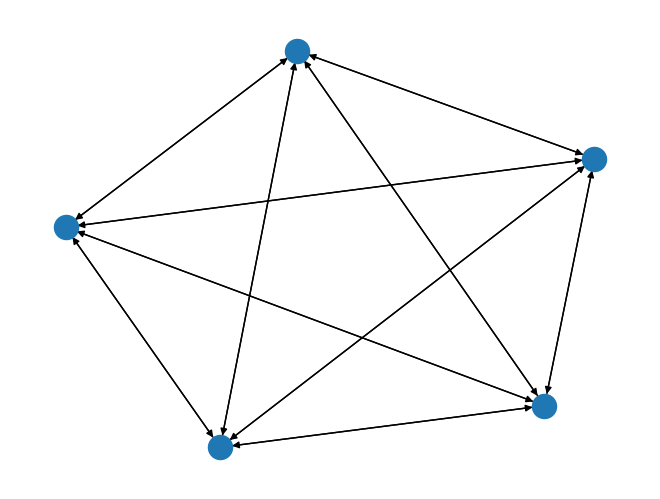

In [19]:
import networkx as nx
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt

def draw_graph(edge_index, gids=[]):
  src = edge_index[0].tolist()
  dst = edge_index[1].tolist()
  edges = [(s, d) for s, d in zip(src, dst)]
  G = nx.from_edgelist(edges)
  nx.draw(G)

#draw_graph(data_list[0].edge_index)
G = pyg_utils.to_networkx(data_list[0])
nx.draw(G)

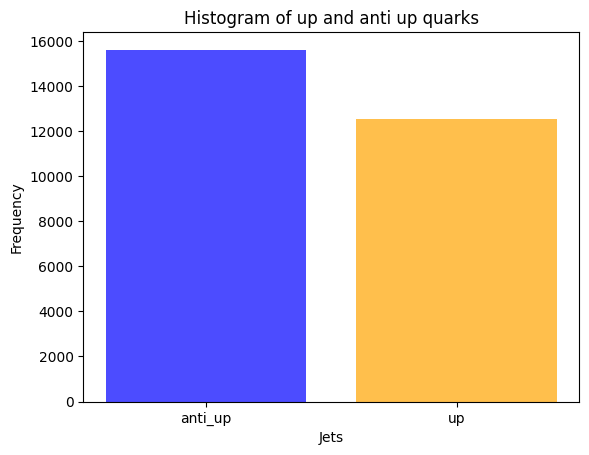

In [17]:
# Find number of up and anti-up quarks
N_up = 0
N_antiup = 0
N_up = sum(data.y.item() == 1 for data in data_list)
N_antiup = sum(data.y.item() == 0 for data in data_list)

# Plot the histogram
values = ['anti_up', 'up']
frequencies = [N_antiup, N_up]

plt.bar(values, frequencies, color=['blue', 'orange'], alpha=0.7)
plt.title('Histogram of up and anti up quarks')
plt.xlabel('Jets')
plt.ylabel('Frequency')
plt.show()

## Split and DataLoader

In [37]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

# Split data into training and test sets
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42) # train_data is a list

# Create DataLoader for batching
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Number of training graphs: {len(train_data)}")
print(f"Number of testing graphs: {len(test_data)}")
print(f"Number of batches in training graphs: {len(train_loader.dataset)/32}")
print(f"Number of batches in testing graphs: {len(test_loader.dataset)/32}")

Number of training graphs: 22498
Number of testing graphs: 5625
Number of batches in training graphs: 703.0625
Number of batches in testing graphs: 175.78125


## GCN model with mean pooling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCNClassifier, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))  # Input to first hidden layer
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))  # Hidden layers
        self.fc = nn.Linear(hidden_dim, output_dim)  # Classification layer
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Pass through GCN layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)            

        # Pooling: Summarize node features into graph-level embedding
        x = global_mean_pool(x, batch)
        # Classification layer
        x = self.fc(x)

        #return F.log_softmax(x, dim=1)
        #return F.sigmoid(x)
        #eturn F.softmax(x, dim=1)
        return x        # depend on loss function


In [31]:
model_output = torch.tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.int32)
target = torch.tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.int32)
model_output = model_output.float()
target = target.float()
loss_fn = nn.BCEWithLogitsLoss()
loss_fn(target, model_output)

tensor(0.7032)

## GCN training

In [64]:
from sklearn.metrics import roc_auc_score

# In train():
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss, correct = 0, 0    
    label_preds = []
    
    for data in train_loader:
        if data.x.size(0) == 0:  # Skip empty batches
            continue
        data = data.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        label = F.one_hot(data.y, num_classes=2).float()
        
        # Clip gradients after loss calculation
        loss = loss_fn(output, label)
        
        if not torch.isnan(loss):
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()
            label_preds.extend(zip(label.cpu().numpy(), pred.cpu().numpy()))            

    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset), label_preds

# In eval()
def eval_step(model, loss_fn, eval_loader, device, is_validation=False):
    model.eval()  # Set the model to evaluation mode
    total_loss, correct = 0, 0
    total_rows = 0
    label_preds = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in eval_loader:
            if batch.x.size(0) == 0:  # Skip empty batches
                continue
            batch = batch.to(device)
            
            pred = model(batch)
            label = batch.y.squeeze(dim=-1)
            label_cat = F.one_hot(label, num_classes=2).float()
            
            loss = loss_fn(pred, label_cat)
            total_loss += loss.item()
            correct += pred.argmax(dim=-1).eq(label).sum().item()
            total_rows += batch.num_graphs
            #total_rows = len(train_loader.dataset)
            label_preds.extend(zip(label.cpu().numpy(), pred.cpu().numpy()))

    return total_loss / total_rows, correct / total_rows, label_preds

def compute_roc_auc(label_preds):
  y_true, y_score = [], []
  for label, preds in label_preds:
    y_true.append(label)
    y_score.append(preds)
  return roc_auc_score(y_true, y_score)


def train_loop(model, optimizer, loss_fn, train_loader, val_loader, device, 
               num_epochs, log_every=5):
  history = []
  for epoch in range(num_epochs):
    train_loss, train_acc, train_label_preds = train(model, train_loader, optimizer, loss_fn, 
                                                     device)
    val_loss, val_acc, val_label_preds = eval_step(model, loss_fn, test_loader, 
                                  device, is_validation=True)
    
    # compute ROC-AUC for training and validation
    #train_auc = compute_roc_auc(train_label_preds)
    train_auc = 0
    #val_auc = compute_roc_auc(val_label_preds)
    val_auc = 0

    history.append((train_loss, train_acc, train_auc, val_loss, val_acc, val_auc))
    if epoch == 0 or (epoch + 1) % log_every == 0:
      print("EPOCH {:3d}, TRAIN loss: {:.5f}, acc: {:.5f}, AUC: {:.5f}, VAL loss: {:.5f}, acc: {:.5f}, AUC: {:.5f}"
        .format(epoch + 1, train_loss, train_acc, train_auc, val_loss, val_acc, val_auc))

  return history

# Parameters
input_dim = data_list[0].x.shape[1]  # Number of input features per node
hidden_dim = 64  # Number of hidden units
output_dim = 2  # Binary classification: up vs anti-up quark
num_layers = 3  # Number of GCN layers
dropout = 0.3  # Dropout rate
epochs = 30  # Number of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, optimizer, and loss function
model = GCNClassifier(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.BCEWithLogitsLoss()

history = train_loop(model, optimizer, loss_fn, train_loader, test_loader, device, epochs)

'''
# Training loop
for epoch in range(epochs):
    train_loss, train_acc, train_label_preds = train(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc, val_label_preds = eval_step(model, loss_fn, test_loader, 
                                  device, is_validation=True)
    print(f"Epoch {epoch+1:02d}:\t Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}\
           Test Loss: {train_loss:.4f} Test Acc: {train_acc:.4f}")
'''

EPOCH   1, TRAIN loss: 0.02058, acc: 0.61157, AUC: 0.00000, VAL loss: 0.02061, acc: 0.59982, AUC: 0.00000
EPOCH   5, TRAIN loss: 0.02023, acc: 0.62681, AUC: 0.00000, VAL loss: 0.02047, acc: 0.60942, AUC: 0.00000
EPOCH  10, TRAIN loss: 0.02017, acc: 0.62801, AUC: 0.00000, VAL loss: 0.02048, acc: 0.60676, AUC: 0.00000
EPOCH  15, TRAIN loss: 0.02010, acc: 0.62619, AUC: 0.00000, VAL loss: 0.02057, acc: 0.60213, AUC: 0.00000
EPOCH  20, TRAIN loss: 0.02011, acc: 0.62814, AUC: 0.00000, VAL loss: 0.02041, acc: 0.61191, AUC: 0.00000
EPOCH  25, TRAIN loss: 0.02008, acc: 0.62810, AUC: 0.00000, VAL loss: 0.02043, acc: 0.61156, AUC: 0.00000
EPOCH  30, TRAIN loss: 0.02009, acc: 0.62681, AUC: 0.00000, VAL loss: 0.02048, acc: 0.61191, AUC: 0.00000


'\n# Training loop\nfor epoch in range(epochs):\n    train_loss, train_acc, train_label_preds = train(model, train_loader, optimizer, loss_fn, device)\n    val_loss, val_acc, val_label_preds = eval_step(model, loss_fn, test_loader, \n                                  device, is_validation=True)\n    print(f"Epoch {epoch+1:02d}:\t Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}           Test Loss: {train_loss:.4f} Test Acc: {train_acc:.4f}")\n'

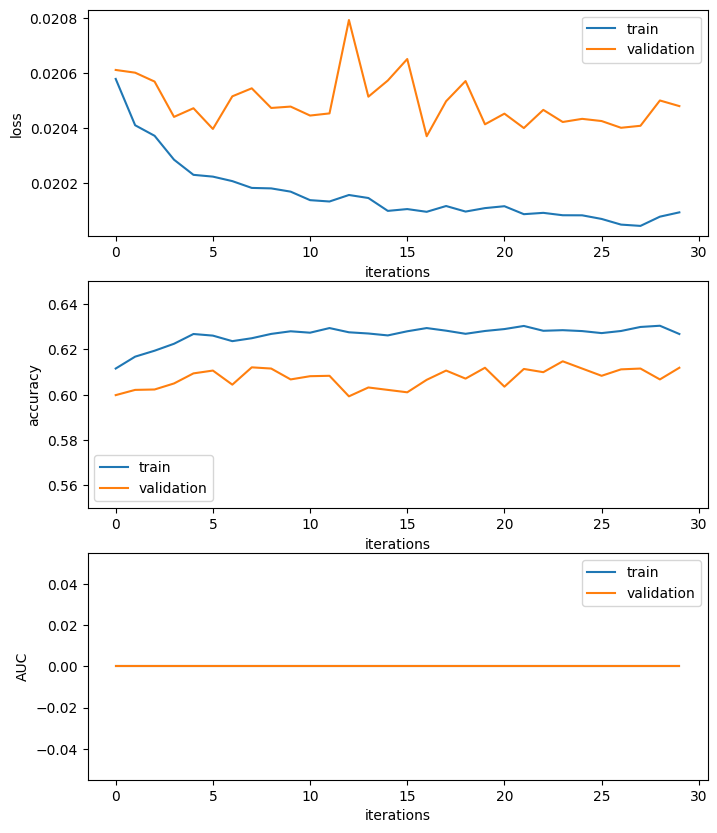

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def display_training_plots(history):
  train_losses, train_accs, train_aucs, val_losses, val_accs, val_aucs = [], [], [], [], [], []
  for train_loss, train_acc, train_auc, val_loss, val_acc, val_auc in history:
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_aucs.append(train_auc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)

  xs = np.arange(len(train_losses))

  plt.figure(figsize=(8, 10))

  plt.subplot(3, 1, 1)
  plt.plot(xs, train_losses, label="train")
  plt.plot(xs, val_losses, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(3, 1, 2)
  plt.plot(xs, train_accs, label="train")
  plt.plot(xs, val_accs, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("accuracy")
  plt.ylim(0.55, 0.65)
  plt.legend(loc="best")

  plt.subplot(3, 1, 3)
  plt.plot(xs, train_aucs, label="train")
  plt.plot(xs, val_aucs, label="validation")
  plt.xlabel("iterations")
  plt.ylabel("AUC")
  plt.legend(loc="best")

  _ = plt.show()


display_training_plots(history)

## GCN model with Max pooling

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool

class GCNClassifier_MAX(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCNClassifier_MAX, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))  # Input to first hidden layer
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))  # Hidden layers
        self.fc = nn.Linear(hidden_dim, output_dim)  # Classification layer
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Pass through GCN layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)            

        # Pooling: Summarize node features into graph-level embedding
        x = global_max_pool(x, batch)
        # Classification layer
        x = self.fc(x)

        #return F.log_softmax(x, dim=1)
        #return F.sigmoid(x)
        #eturn F.softmax(x, dim=1)
        return x        # depend on loss function


In [75]:
model_MAX = GCNClassifier_MAX(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model_MAX.parameters(), lr=0.001, weight_decay=5e-4)
history_MAX = train_loop(model_MAX, optimizer, loss_fn, train_loader, test_loader, device, epochs)

EPOCH   1, TRAIN loss: 0.02063, acc: 0.60797, AUC: 0.00000, VAL loss: 0.02076, acc: 0.59893, AUC: 0.00000
EPOCH   5, TRAIN loss: 0.02020, acc: 0.62659, AUC: 0.00000, VAL loss: 0.02053, acc: 0.60622, AUC: 0.00000
EPOCH  10, TRAIN loss: 0.02018, acc: 0.62454, AUC: 0.00000, VAL loss: 0.02044, acc: 0.60658, AUC: 0.00000
EPOCH  15, TRAIN loss: 0.02010, acc: 0.62828, AUC: 0.00000, VAL loss: 0.02043, acc: 0.60942, AUC: 0.00000
EPOCH  20, TRAIN loss: 0.02007, acc: 0.62779, AUC: 0.00000, VAL loss: 0.02053, acc: 0.60604, AUC: 0.00000
EPOCH  25, TRAIN loss: 0.02008, acc: 0.62979, AUC: 0.00000, VAL loss: 0.02047, acc: 0.60996, AUC: 0.00000
EPOCH  30, TRAIN loss: 0.02005, acc: 0.63077, AUC: 0.00000, VAL loss: 0.02046, acc: 0.60836, AUC: 0.00000


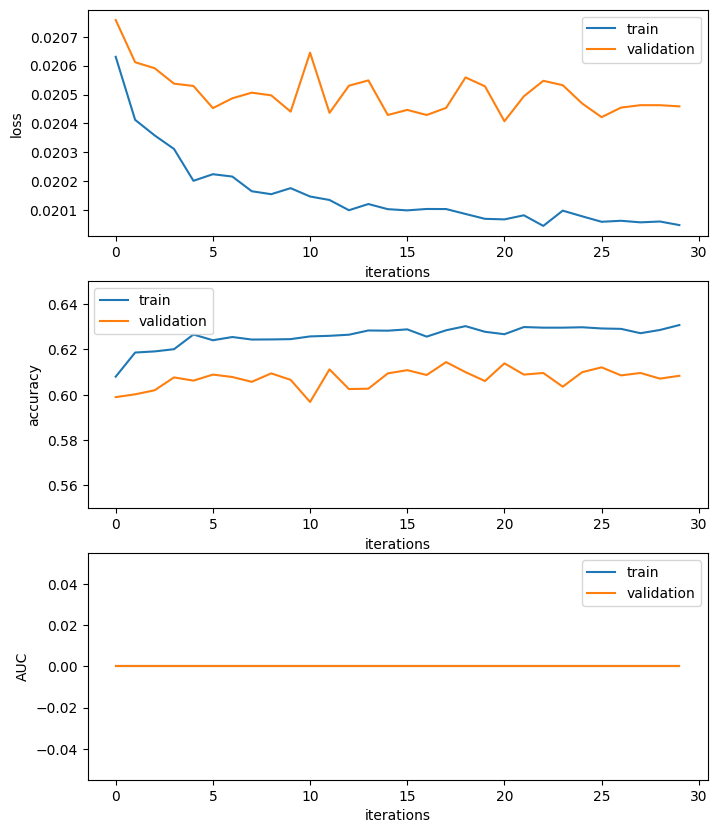

In [76]:
display_training_plots(history_MAX)

## GraphSAGE model